## The idea

So the idea while working with the files was really to be able to run LDA on the conversations to kind of try and get topics around the conversations. LDA is a powerful tool for topic modelling. 

While working with the data I had to do a lot of preprocessing before even being able to use LDA on the corpus. 

I used a bunch of libraries. Mainly genism, nltk, pyLDAvis for processing the data and visualizing the model. 

The idea behind the project was really to be able to actually have distinguished topics so that we can further feed in more data to the model and let the model classify which kind of topic it is. 

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.

#### Feel free to reach out to me if you have any doubts or are having any issue understanding what is being done in the notebook. I was honestly just experimenting so a lot of the code here is a little messy. Feel free to contact me and talk to me about it at: gsoni@wisc.edu

In [1]:
import json
import pandas as pd
import os
import re
from wordcloud import WordCloud

#LDA
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import nltk.stem as stemmer
from nltk.stem import *
from nltk.stem.wordnet import WordNetLemmatizer

#import pyLDAvis.gensim
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

[nltk_data] Downloading package stopwords to /Users/girik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This step is mostly to preprocess the data and kind of unify it based on conversation instead of speakers. In the end I do save a new file with different conversations so now this is step is not as important. 

In the end, I make a pandas dataframe that we can work with throughout the notebook. 

In [2]:
#All of this is for Speaker 0 Currently just working on Spring 19
filepath = "../Transcribe_json_S19/spk_0_out"
filename = []
for files in os.listdir(filepath):
    filename.append(files)
filename.sort()
StuID = []
for files in filename:
    #print(files)
    StuID.append(files[10:13])
pd_list = []
for i in range(len(filename)):
    new_list = []
    dict1 = {}
    dest = "../JSON 0S19/" + StuID[i]+".json"
    #print(dest)
    # creating dictionary
    with open("../Transcribe_json_S19/spk_0_out/"+filename[i]) as fh:

        for line in fh:

            # reads each line and trims of extra the spaces 
            # and gives only the valid words
            command, description = line.strip().split(None, 1)

            dict1[command] = description.strip()

    # creating json file
    # the JSON file is named as test1
    #dest = "../JSON S19/test1.json"
    for text in dict1:
        dict1[text] = dict1[text][7:-1]
    new_list.append(dict1)
    out_file = open(dest, "w")
    json.dump(dict1, out_file, indent = 4, sort_keys = False)
    df = pd.DataFrame([dict1])
    no = len(list(df))
    l = []
    for g in range(no):
        l.append("text")
    df.columns = l
    newdf = df.groupby(df.columns, axis=1).agg(lambda x: x.apply(lambda y: ','.join([str(l) for l in y if str(l) != "nan"]), axis=1))
    newdf.index = [StuID[i]]
    newdf.index.name = "StuID"
    pd_list.append(newdf)
    out_file.close()
final0 = pd.concat(pd_list)  
final0 = final0.reset_index()
final0 = final0.astype({'StuID': 'int64'})



#All of this is for Speaker 1 S19
filepath = "../Transcribe_json_S19/spk_1_out"
filename = []
for files in os.listdir(filepath):
    filename.append(files)
filename.sort()
StuID = []
for files in filename:
    #print(files)
    StuID.append(files[10:13])

pd_list = []
for i in range(len(filename)):
    new_list = []
    dict1 = {}
    dest = "../JSON 1S19/" + StuID[i]+".json"
    #print(dest)
    # creating dictionary
    with open("../Transcribe_json_S19/spk_1_out/"+filename[i]) as fh:

        for line in fh:

            # reads each line and trims of extra the spaces 
            # and gives only the valid words
            command, description = line.strip().split(None, 1)

            dict1[command] = description.strip()

    # creating json file
    # the JSON file is named as test1
    #dest = "../JSON S19/test1.json"
    for text in dict1:
        dict1[text] = dict1[text][7:-1]
    new_list.append(dict1)
    out_file = open(dest, "w")
    json.dump(dict1, out_file, indent = 4, sort_keys = False)
    df = pd.DataFrame([dict1])
    no = len(list(df))
    l = []
    for g in range(no):
        l.append("text")
    df.columns = l
    newdf = df.groupby(df.columns, axis=1).agg(lambda x: x.apply(lambda y: ','.join([str(l) for l in y if str(l) != "nan"]), axis=1))
    newdf.index = [StuID[i]]
    newdf.index.name = "StuID"
    pd_list.append(newdf)
    out_file.close()
final1 = pd.concat(pd_list)  
final1 = final1.reset_index()
final1.dtypes
final1 = final1.astype({'StuID': 'int64'})

#Mixing now based on the seller and buyers keys
keydf = pd.read_csv("../buyer_seller_key/TranscribeBuyerID_S19.csv")
final0 = final0.merge(keydf, on = "StuID")
final1 = final1.merge(keydf, on = "StuID")

buyer0 = final0[final0['Buyer']==0]
seller0 = final0[final0['Seller']==0]
buyer1 = final1[final1['Buyer']==1]
seller1 = final1[final1['Seller']==1]


buyer_final = buyer0.append(buyer1)
buyer_final= buyer_final.sort_values(by=["StuID"])
seller_final = seller0.append(seller1)
seller_final = seller_final.sort_values(by=["StuID"])

buyer_final = buyer_final.drop(["video_id","Buyer", "Seller"], axis =1)
seller_final = seller_final.drop(["video_id","Buyer", "Seller"], axis =1)




Since the goal of this analysis is to perform topic modeling, let’s focus only on the text data from each paper, and drop other metadata columns. Let’s also perform a simple preprocessing on the column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text


### Preprocessing the raw text
#### This involves the following:

Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
Words that have fewer than 3 characters are removed.
All stopwords are removed.
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.
Words are stemmed — words are reduced to their root form.
We use the NLTK and gensim libraries to perform the preprocessing

In [3]:
# Data Cleaning 
# Remove punctuation
seller_final['paper_text_processed'] = \
seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
seller_final['paper_text_processed'] = \
seller_final['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers


#import stemmer 
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

new_list = []
for i in seller_final.paper_text_processed:
    #print(i)
    new_list.append(preprocess(i))

another_list = []
for i in new_list:
    g = ' '.join(i)
    another_list.append(g)

seller_final['paper_text_processed'] = another_list

seller_final['paper_text_processed'].head()


<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
/var/folders/yr/9w_z4h7x01xb__v_97gjtpp40000gn/T/ipykernel_10258/3818842670.py:4: DeprecationWarning: invalid escape sequence \.
  seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))


0    thank meet today yeah good good weak talk secr...
1    come hello good jami salesforc nice meet jacki...
2    come brian hunter salesforc jake mari jake rya...
3    come high salesforc jacob liberti mutual sorri...
4    forc meet youso hearwear question concern feel...
Name: paper_text_processed, dtype: object

### Exploratory Analysis
To verify whether the preprocessing, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

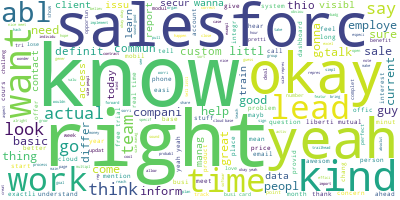

In [4]:
# Join the different processed titles together.
long_string = ','.join(list(seller_final['paper_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

This was a step I was relying on earlier(When i started) to eliminate stop words. all of the data pre processing has already been done now though.

In [5]:
stop_words = gensim.parsing.preprocessing.STOPWORDS
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = seller_final.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['thank', 'meet', 'today', 'yeah', 'good', 'good', 'weak', 'talk', 'secretari', 'outsid', 'offic', 'form', 'come', 'wed', 'yeah', 'wed', 'marriag', 'grand', 'yeah', 'grand', 'yeah', 'definit', 'definit', 'want', 'thio', 'ahead', 'appreci', 'thank', 'come', 'today']


In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 3), (1, 2), (2, 1), (3, 2), (4, 14), (5, 1), (6, 2), (7, 1), (8, 6), (9, 1), (10, 1), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 2), (17, 3), (18, 1), (19, 2), (20, 6), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 2), (28, 3), (29, 1)]


### LDA model training
To keep things simple, we’ll keep all the parameters to default except for inputting the number of topics. For this tutorial, we will build a model with 10 topics where each topic is a combination of keywords, and each keyword contributes a certain weightage to the topic.

In [7]:
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.041*"like" + 0.018*"salesforc" + 0.018*"yeah" + 0.016*"right" + '
  '0.016*"okay" + 0.015*"know" + 0.014*"want" + 0.012*"time" + 0.010*"kind" + '
  '0.009*"actual"'),
 (1,
  '0.024*"like" + 0.024*"know" + 0.018*"okay" + 0.017*"right" + 0.016*"yeah" + '
  '0.015*"salesforc" + 0.013*"time" + 0.011*"kind" + 0.010*"sale" + '
  '0.009*"want"'),
 (2,
  '0.027*"like" + 0.024*"okay" + 0.019*"know" + 0.018*"yeah" + 0.018*"kind" + '
  '0.017*"right" + 0.015*"salesforc" + 0.012*"time" + 0.010*"want" + '
  '0.010*"abl"'),
 (3,
  '0.037*"like" + 0.020*"yeah" + 0.017*"know" + 0.013*"okay" + 0.012*"right" + '
  '0.012*"sale" + 0.012*"salesforc" + 0.011*"time" + 0.010*"kind" + '
  '0.010*"want"')]


## Analyzing LDA model results
Now that we have a trained model let’s visualize the topics for interpretability. To do so, we’ll use a popular visualization package, pyLDAvis which is designed to help interactively with:

(1) Better understanding and interpreting individual topics, and

(2) Better understanding the relationships between the topics.


For (1), you can manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ parameter. This can help when you’re trying to assign a human interpretable name or “meaning” to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

In [8]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/s

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004602 -0.003625       1        1  39.702215
1      0.003056 -0.000357       2        1  27.360424
2      0.003607 -0.001304       3        1  25.142525
3     -0.002061  0.005286       4        1   7.794836, topic_info=       Term         Freq        Total Category  logprob  loglift
128    like  1327.000000  1327.000000  Default  30.0000  30.0000
281    yeah   725.000000   725.000000  Default  29.0000  29.0000
123    know   772.000000   772.000000  Default  28.0000  28.0000
211    sale   356.000000   356.000000  Default  27.0000  27.0000
121    kind   508.000000   508.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
0       abl    20.716938   356.456615   Topic4  -5.0440  -0.2936
138   manag    14.807018   201.494158   Topic4  -5.3799  -0.0590
101   great    15.726846   230.072910   Topic4  -5.3196  -0.1313
115  inform    17.008370   277.575837   Topic4  -5.2413  -0.2407
107    help    15.761632   244.725603   Topic4  -5.3174  -0.1909

[345 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.426419     abl
0         2  0.238458     abl
0         3  0.277734     abl
0         4  0.058913     abl
1         1  0.409398  access
...     ...       ...     ...
795       1  0.280956   youso
795       2  0.421434   youso
795       3  0.140478   youso
795       4  0.140478   youso
4121      1  0.626913   youum

[617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

## Below here are multiple attempts made by me to make the topics more relevant by processing the data more. Removing words that are too common is one of the ways i tried. I also tried a method called bag-of-words. The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. These were some of my ways to just play around and get better results. 

# Goals for the future: 
Separate nouns, adverbs, etc. 
Like descriptive verbs 

Create a dictionary of nouns and adverbs

POS Tagging  for NLP 

Frequency concept miner
Mining for concepts
	1	Use POS taggers to separate high frequency nouns and noun phrases from adjectives and adverbs ( content vs style)
	2	Create a good repository of all code ( with explanations where needed). A short readme file would also be good
	3	Below I am sharing a table of common linguistic styles that you can refer when working with adjectives and adverbs

### The main goal, really is to be able to run LDA and get relevant topics to make some sense of. Thr topics this model currently shows are not that easy to understand. The model doesn't "name" topics, and can only cluster like words. Maybe with enough processing, or even some other alogirthm, it is possible to cluster all these words in different relevant topics. 

In [9]:
dictionary = gensim.corpora.Dictionary(new_list)
dictionary

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in new_list]

In [15]:
seller_final['paper_text_processed'] = \
seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
seller_final['paper_text_processed'] = \
seller_final['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers

another_list = []
for i in seller_final.paper_text_processed:
    another_list.append(i.split(' '))

<>:2: DeprecationWarning: invalid escape sequence \.
<>:2: DeprecationWarning: invalid escape sequence \.
/var/folders/yr/9w_z4h7x01xb__v_97gjtpp40000gn/T/ipykernel_10258/3996084668.py:2: DeprecationWarning: invalid escape sequence \.
  seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))


In [16]:
seller_final

,StuID,text,paper_text_processed
0,103,Thank you so much for meeting with me today. Y...,thank you so much for meeting with me today ye...
1,104,That's 30. Coming. Hello. How are you? Hi. I'm...,that's 30 coming hello how are you hi i'm doin...
2,106,No. Come in. Hi. I'm Brian Hunter from Salesfo...,no come in hi i'm brian hunter from salesforce...
3,108,"Come on. Hey, High five from Salesforce. Hey t...",come on hey high five from salesforce hey ther...
4,109,"Hi. I'm forced to meet you,So when I hear,wear...",hi i'm forced to meet youso when i hearwear th...
...,...,...,...
88,803,I'm sorry I didn't get your name. Jackie. Jack...,i'm sorry i didn't get your name jackie jackie...
89,805,My name is wealthy and representative themselv...,my name is wealthy and representative themselv...
90,815,"show me that. Come in. Uh, no. I'm Salesforce ...",show me that come in uh no i'm salesforce dot ...
93,822,conversation when I'm going back to the weeken...,conversation when i'm going back to the weeken...


In [17]:
dictionary = gensim.corpora.Dictionary(new_list)

In [18]:
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 access
2 accomplish
3 account
4 actual
5 add
6 advis
7 ahad
8 ahead
9 allmor
10 angl


In [19]:
'''
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n= 100000)

In [20]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in new_list]

In [21]:
'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 5 ("basi") appears 1 time.
Word 11 ("clear") appears 1 time.
Word 21 ("doubl") appears 3 time.
Word 30 ("fara") appears 3 time.
Word 43 ("intern") appears 2 time.
Word 56 ("outsid") appears 1 time.
Word 57 ("overal") appears 1 time.
Word 58 ("overview") appears 1 time.
Word 68 ("reach") appears 1 time.
Word 79 ("share") appears 1 time.
Word 82 ("somebodi") appears 1 time.
Word 92 ("total") appears 3 time.
Word 103 ("annual") appears 1 time.
Word 106 ("aspect") appears 1 time.
Word 108 ("believ") appears 2 time.
Word 109 ("benefici") appears 2 time.
Word 112 ("correct") appears 1 time.
Word 127 ("familiar") appears 2 time.
Word 134 ("hacker") appears 1 time.
Word 143 ("improv") appears 1 time.
Word 152 ("locat") appears 1 time.
Word 166 ("posit") appears 1 time.
Word 188 ("way") appears 1 time.
Word 190 ("wonder") appears 3 time.
Word 192 ("answer") appears 1 time.
Word 209 ("initi") appears 1 time.
Word 215 ("leav") appears 1 time.
Word 232 ("wait") appears 1 time.
Word 237 ("ask"

In [22]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.053*"repres" + 0.015*"field" + 0.013*"addit" + 0.013*"wouldn" + 0.011*"correct" + 0.010*"aspect" + 0.009*"valu" + 0.009*"click" + 0.009*"share" + 0.009*"store"


Topic: 1 
Words: 0.011*"reach" + 0.010*"move" + 0.009*"face" + 0.009*"sort" + 0.008*"subscript" + 0.007*"expand" + 0.007*"click" + 0.007*"save" + 0.007*"affect" + 0.007*"recommend"


Topic: 2 
Words: 0.013*"main" + 0.012*"child" + 0.011*"solv" + 0.010*"organ" + 0.010*"touch" + 0.010*"andi" + 0.009*"coach" + 0.009*"program" + 0.008*"save" + 0.008*"improv"


Topic: 3 
Words: 0.012*"program" + 0.012*"obvious" + 0.011*"tool" + 0.010*"sort" + 0.010*"essenti" + 0.008*"implement" + 0.007*"softwar" + 0.007*"repres" + 0.007*"address" + 0.006*"grow"


Topic: 4 
Words: 0.014*"platform" + 0.011*"effici" + 0.010*"teach" + 0.009*"grow" + 0.009*"build" + 0.009*"main" + 0.009*"test" + 0.008*"overal" + 0.008*"instead" + 0.008*"sens"


Topic: 5 
Words: 0.012*"easier" + 0.012*"caus" + 0.011*"valu" + 0.011*"softwar" + 0.011*"cl

In [23]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(8))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(8) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/s

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.035274 -0.009522       1        1  21.925680
3     -0.015908 -0.024652       2        1  20.031888
4     -0.012780 -0.078478       3        1  12.525227
2     -0.018764 -0.055737       4        1  12.039264
0     -0.059547  0.011843       5        1  11.821472
6     -0.041270 -0.008358       6        1   8.956858
5     -0.019967  0.160983       7        1   8.545990
7      0.203510  0.003920       8        1   4.153621, topic_info=         Term       Freq      Total Category  logprob  loglift
223    repres  89.000000  89.000000  Default  30.0000  30.0000
242   chatter  39.000000  39.000000  Default  29.0000  29.0000
162   obvious  34.000000  34.000000  Default  28.0000  28.0000
410     agent  21.000000  21.000000  Default  27.0000  27.0000
82   somebodi  23.000000  23.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
117    depend   3.083337  23.334760   Topic8  -4.8353   1.1573
133      grow   3.450828  41.062250   Topic8  -4.7227   0.7047
310      pull   3.121312  35.740907   Topic8  -4.8230   0.7431
256     haven   2.842637  28.766734   Topic8  -4.9166   0.8667
62   password   2.826445  25.431452   Topic8  -4.9223   0.9842

[452 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
454       1  0.118561    accur
454       2  0.118561    accur
454       4  0.118561    accur
454       5  0.237121    accur
454       7  0.355682    accur
...     ...       ...      ...
581       8  0.554595   yookay
235       3  0.134371  youyeah
235       4  0.134371  youyeah
235       5  0.403114  youyeah
235       6  0.268743  youyeah

[1584 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1, 7, 6, 8])

In [24]:
''' Found Another Way to do this with different type of data cleaning. Gives better results while and can be toyed around with better
'''

seller_final = pd.concat([buyer_final,seller_final])
# Data Cleaning 
# Remove punctuation
seller_final['paper_text_processed'] = \
seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
seller_final['paper_text_processed'] = \
seller_final['paper_text_processed'].map(lambda x: x.lower())
# Print out the first rows of papers


#import stemmer 
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
            
    return result

new_list = []
for i in seller_final.paper_text_processed:
    #print(i)
    new_list.append(preprocess(i))

    
    
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_words = list(sent_to_words(new_list))
# remove stop words
new_list = remove_stopwords(data_words)



<>:8: DeprecationWarning: invalid escape sequence \.
<>:8: DeprecationWarning: invalid escape sequence \.
/var/folders/yr/9w_z4h7x01xb__v_97gjtpp40000gn/T/ipykernel_10258/3310366347.py:8: DeprecationWarning: invalid escape sequence \.
  seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))


In [25]:

dictionary = gensim.corpora.Dictionary(new_list)
'''
Checking dictionary created
'''
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 access
2 activ
3 ahead
4 answeriny
5 argu
6 ask
7 better
8 board
9 boss
10 breach


In [26]:
'''
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n= 100000)

'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in new_list]

'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 1 ("ask") appears 2 time.
Word 5 ("build") appears 2 time.
Word 6 ("button") appears 1 time.
Word 7 ("class") appears 1 time.
Word 8 ("control") appears 2 time.
Word 13 ("doubl") appears 1 time.
Word 15 ("everybodi") appears 1 time.
Word 21 ("frustrat") appears 5 time.
Word 22 ("gotta") appears 2 time.
Word 29 ("miss") appears 1 time.
Word 37 ("press") appears 1 time.
Word 40 ("quick") appears 1 time.
Word 45 ("search") appears 1 time.
Word 46 ("sell") appears 2 time.
Word 50 ("solv") appears 1 time.
Word 52 ("teach") appears 1 time.
Word 55 ("user") appears 1 time.
Word 56 ("wait") appears 1 time.
Word 58 ("abil") appears 1 time.
Word 59 ("answer") appears 1 time.
Word 65 ("benefit") appears 1 time.
Word 83 ("hope") appears 1 time.
Word 106 ("read") appears 1 time.
Word 108 ("respons") appears 1 time.
Word 116 ("track") appears 1 time.
Word 118 ("type") appears 1 time.
Word 144 ("higher") appears 1 time.
Word 145 ("idea") appears 1 time.
Word 158 ("north") appears 1 time.
Word 18

In [27]:
# LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
# lda_model = gensim.models.LdaModel(bow_corpus, 
#                                    num_topics = 10, 
#                                    id2word = dictionary,                                    
#                                    passes = 50)

# LDA multicore 
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 8, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.013*"repres" + 0.009*"awesom" + 0.008*"integr" + 0.007*"page" + 0.007*"cool" + 0.007*"multipl" + 0.007*"quick" + 0.007*"simpl" + 0.007*"activ" + 0.007*"badg"


Topic: 1 
Words: 0.012*"track" + 0.011*"specif" + 0.011*"integr" + 0.009*"benefit" + 0.008*"enter" + 0.008*"program" + 0.007*"believ" + 0.007*"multipl" + 0.007*"chang" + 0.007*"subscript"


Topic: 2 
Words: 0.025*"opportun" + 0.019*"essenti" + 0.012*"applic" + 0.011*"moment" + 0.009*"softwar" + 0.009*"coach" + 0.009*"depend" + 0.008*"group" + 0.008*"depart" + 0.007*"matter"


Topic: 3 
Words: 0.013*"excel" + 0.013*"hous" + 0.013*"term" + 0.012*"build" + 0.011*"forecast" + 0.010*"sunday" + 0.010*"pipelin" + 0.010*"monday" + 0.009*"scott" + 0.008*"past"


Topic: 4 
Words: 0.024*"control" + 0.022*"somebodi" + 0.014*"frustrat" + 0.013*"ask" + 0.013*"sell" + 0.012*"onlin" + 0.011*"gotta" + 0.009*"competitor" + 0.009*"answer" + 0.008*"leav"


Topic: 5 
Words: 0.018*"coach" + 0.010*"progress" + 0.010*"repres" + 0.009

In [28]:
#Seller

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(8))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(8) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043695  0.007545       1        1  22.293976
6     -0.017259 -0.023254       2        1  17.585909
7      0.007169  0.002833       3        1  14.937284
1     -0.046907  0.005214       4        1  12.293926
3      0.072858 -0.164089       5        1  11.306051
5     -0.057406  0.009077       6        1  10.222498
4      0.168227  0.104009       7        1   6.935866
2     -0.082986  0.058664       8        1   4.424490, topic_info=          Term       Freq      Total Category  logprob  loglift
215   opportun  93.000000  93.000000  Default  30.0000  30.0000
8      control  68.000000  68.000000  Default  29.0000  29.0000
51    somebodi  71.000000  71.000000  Default  28.0000  28.0000
140    essenti  56.000000  56.000000  Default  27.0000  27.0000
67       coach  91.000000  91.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
15   everybodi   5.489660  56.637178   Topic8  -5.1151   0.7842
160    obvious   5.679720  72.297906   Topic8  -5.0810   0.5741
13       doubl   5.563079  66.158165   Topic8  -5.1018   0.6421
434       sort   5.002959  63.454233   Topic8  -5.2079   0.5777
23        hack   4.919099  59.249273   Topic8  -5.2248   0.6294

[502 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
58        1  0.126101     abil
58        2  0.126101     abil
58        3  0.075661     abil
58        4  0.176542     abil
58        5  0.050440     abil
...     ...       ...      ...
57        1  0.781482  youokay
57        2  0.111640  youokay
57        7  0.111640  youokay
917       1  0.525964    youso
917       8  0.394473    youso

[1868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 8, 2, 4, 6, 5, 3])

In [29]:
#buyer

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(8))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(8) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043695  0.007545       1        1  22.289195
6     -0.017259 -0.023254       2        1  17.588031
7      0.007169  0.002833       3        1  14.932067
1     -0.046907  0.005214       4        1  12.301036
3      0.072858 -0.164089       5        1  11.306050
5     -0.057406  0.009077       6        1  10.221512
4      0.168227  0.104009       7        1   6.936664
2     -0.082986  0.058664       8        1   4.425445, topic_info=          Term       Freq      Total Category  logprob  loglift
215   opportun  93.000000  93.000000  Default  30.0000  30.0000
8      control  68.000000  68.000000  Default  29.0000  29.0000
51    somebodi  71.000000  71.000000  Default  28.0000  28.0000
140    essenti  56.000000  56.000000  Default  27.0000  27.0000
67       coach  91.000000  91.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
15   everybodi   5.490844  56.636029   Topic8  -5.1151   0.7842
160    obvious   5.680945  72.296962   Topic8  -5.0810   0.5741
13       doubl   5.564279  66.158019   Topic8  -5.1018   0.6421
434       sort   5.004038  63.448515   Topic8  -5.2079   0.5778
23        hack   4.920160  59.252739   Topic8  -5.2248   0.6293

[502 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
58        1  0.126094     abil
58        2  0.126094     abil
58        3  0.075656     abil
58        4  0.176532     abil
58        5  0.050438     abil
...     ...       ...      ...
57        1  0.781592  youokay
57        2  0.111656  youokay
57        7  0.111656  youokay
917       1  0.525987    youso
917       8  0.394490    youso

[1868 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 8, 2, 4, 6, 5, 3])

In [30]:
#Both

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(8))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(8) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/girik/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.043695  0.007545       1        1  22.294068
6     -0.017259 -0.023254       2        1  17.600382
7      0.007169  0.002833       3        1  14.927101
1     -0.046907  0.005214       4        1  12.290291
3      0.072858 -0.164089       5        1  11.305618
5     -0.057406  0.009077       6        1  10.222608
4      0.168227  0.104009       7        1   6.935175
2     -0.082986  0.058664       8        1   4.424757, topic_info=          Term       Freq      Total Category  logprob  loglift
215   opportun  93.000000  93.000000  Default  30.0000  30.0000
8      control  68.000000  68.000000  Default  29.0000  29.0000
51    somebodi  71.000000  71.000000  Default  28.0000  28.0000
140    essenti  56.000000  56.000000  Default  27.0000  27.0000
67       coach  91.000000  91.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
15   everybodi   5.489991  56.633015   Topic8  -5.1151   0.7843
160    obvious   5.680062  72.301643   Topic8  -5.0810   0.5741
13       doubl   5.563415  66.164749   Topic8  -5.1018   0.6420
434       sort   5.003261  63.442594   Topic8  -5.2079   0.5779
23        hack   4.919396  59.253591   Topic8  -5.2248   0.6293

[502 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
58        1  0.126102     abil
58        2  0.126102     abil
58        3  0.075661     abil
58        4  0.176543     abil
58        5  0.050441     abil
...     ...       ...      ...
57        1  0.781460  youokay
57        2  0.111637  youokay
57        7  0.111637  youokay
917       1  0.525966    youso
917       8  0.394475    youso

[1867 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 8, 2, 4, 6, 5, 3])

In [31]:
''' Found Another Way to do this with different type of data cleaning. Gives better results while and can be toyed around with better
'''


def givetopics(seller_final, nt):
    #seller_final = pd.concat([buyer_final,seller_final])
    # Data Cleaning 
    # Remove punctuation
    seller_final['paper_text_processed'] = \
    seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))
    # Convert the titles to lowercase
    seller_final['paper_text_processed'] = \
    seller_final['paper_text_processed'].map(lambda x: x.lower())
    # Print out the first rows of papers


    #import stemmer 
    stemmer = PorterStemmer()
    def lemmatize_stemming(text):
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    # Tokenize and lemmatize
    def preprocess(text):
        result=[]
        for token in gensim.utils.simple_preprocess(text) :
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                result.append(lemmatize_stemming(token))

        return result

    new_list = []
    for i in seller_final.paper_text_processed:
        #print(i)
        new_list.append(preprocess(i))



    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
    def sent_to_words(sentences):
        for sentence in sentences:
            # deacc=True removes punctuations
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) 
                 if word not in stop_words] for doc in texts]
    data_words = list(sent_to_words(new_list))
    # remove stop words
    new_list = remove_stopwords(data_words)


    dictionary = gensim.corpora.Dictionary(new_list)
    '''
    Checking dictionary created
    '''
    count = 0
    for k, v in dictionary.iteritems():
        print(k, v)
        count += 1
        if count > 10:
            break

    '''
    Remove very rare and very common words:

    - words appearing less than 15 times
    - words appearing in more than 10% of all documents
    '''
    dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n= 100000)

    '''
    Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
    words and how many times those words appear. Save this to 'bow_corpus'
    '''
    bow_corpus = [dictionary.doc2bow(doc) for doc in new_list]

    '''
    Preview BOW for our sample preprocessed document
    '''
    document_num = 20
    bow_doc_x = bow_corpus[document_num]

    for i in range(len(bow_doc_x)):
        print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                         dictionary[bow_doc_x[i][0]], 
                                                         bow_doc_x[i][1]))

    # LDA mono-core -- fallback code in case LdaMulticore throws an error on your machine
    # lda_model = gensim.models.LdaModel(bow_corpus, 
    #                                    num_topics = 10, 
    #                                    id2word = dictionary,                                    
    #                                    passes = 50)

    # LDA multicore 
    '''
    Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
    '''
    # TODO
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = nt, 
                                       id2word = dictionary,                                    
                                       passes = 10,
                                       workers = 2)

    for idx, topic in lda_model.print_topics(-1):
        print("Topic: {} \nWords: {}".format(idx, topic ))
        print("\n")


    #Seller

    return lda_model, bow_corpus, dictionary

<>:10: DeprecationWarning: invalid escape sequence \.
<>:10: DeprecationWarning: invalid escape sequence \.
/var/folders/yr/9w_z4h7x01xb__v_97gjtpp40000gn/T/ipykernel_10258/888285848.py:10: DeprecationWarning: invalid escape sequence \.
  seller_final['text'].map(lambda x: re.sub('[,\.!?]', '', x))


In [32]:
num_topics = 15
lda_model, bow_corpus, dictionary = givetopics(pd.concat([seller_final,buyer_final]), num_topics)

0 abl
1 access
2 activ
3 ahead
4 answeriny
5 argu
6 ask
7 better
8 board
9 boss
10 breach
Word 2 ("ask") appears 2 time.
Word 6 ("build") appears 2 time.
Word 7 ("button") appears 1 time.
Word 8 ("class") appears 1 time.
Word 10 ("control") appears 2 time.
Word 14 ("doubl") appears 1 time.
Word 16 ("everybodi") appears 1 time.
Word 22 ("frustrat") appears 5 time.
Word 24 ("gotta") appears 2 time.
Word 32 ("miss") appears 1 time.
Word 40 ("press") appears 1 time.
Word 43 ("quick") appears 1 time.
Word 50 ("search") appears 1 time.
Word 51 ("sell") appears 2 time.
Word 55 ("solv") appears 1 time.
Word 57 ("teach") appears 1 time.
Word 61 ("user") appears 1 time.
Word 62 ("wait") appears 1 time.
Word 64 ("abil") appears 1 time.
Word 65 ("answer") appears 1 time.
Word 71 ("benefit") appears 1 time.
Word 90 ("hope") appears 1 time.
Word 116 ("read") appears 1 time.
Word 118 ("respons") appears 1 time.
Word 128 ("track") appears 1 time.
Word 130 ("type") appears 1 time.
Word 158 ("higher") a

In [33]:
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/girik/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.001113 -0.009979       1        1  16.526312
8     -0.031934  0.031614       2        1  14.178854
5     -0.016109  0.000187       3        1   9.858450
0     -0.083544 -0.116195       4        1   8.104907
4     -0.054979  0.019985       5        1   7.677099
10     0.070026  0.062552       6        1   7.273216
12     0.198335 -0.123002       7        1   6.204295
7      0.021757  0.174584       8        1   5.515623
9      0.024671  0.025296       9        1   5.285516
1      0.121052  0.039403      10        1   4.875398
2     -0.052819 -0.104018      11        1   3.627828
14    -0.030523  0.101084      12        1   3.186680
13    -0.105578  0.044216      13        1   2.668087
6      0.090512 -0.068040      14        1   2.602602
3     -0.149753 -0.077687      15        1   2.415134, topic_info=        Term        Freq       Total Category  logprob  loglift
716  respect   85.000000   85.000000  Default  30.0000  30.0000
706    modul  131.000000  131.000000  Default  29.0000  29.0000
10   control  117.000000  117.000000  Default  28.0000  28.0000
117   repres  108.000000  108.000000  Default  27.0000  27.0000
534  softwar  125.000000  125.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
803  multipl    5.575615  112.165896  Topic15  -4.9448   0.7218
5     breach    4.972775   69.038715  Topic15  -5.0592   1.0927
154  essenti    4.980236   82.970382  Topic15  -5.0577   0.9104
253   specif    5.247010  125.717988  Topic15  -5.0055   0.5470
670  mention    4.873092  181.594118  Topic15  -5.0795   0.1054

[948 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
64        1  0.046279    abil
64        2  0.030853    abil
64        3  0.231397    abil
64        4  0.092559    abil
64        5  0.169691    abil
...     ...       ...     ...
334      10  0.124258   young
334      12  0.124258   young
334      14  0.124258   young
1194      2  0.665451  youtub
1194      9  0.221817  youtub

[3772 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 9, 6, 1, 5, 11, 13, 8, 10, 2, 3, 15, 14, 7, 4])